In [30]:
!sudo apt-get update
!pt-get install -y xvfb python-opengl ffmpeg
!pip install pyvirtualdisplay
!pip install pyglet xvfbwrapper
!pip install pyvirtualdisplay
!pip install xvfbwrapper
!sudo apt-get install python-box2d
!pip install -q swig
!pip install -q gymnasium[box2d]
!sudo apt-get install xvfb

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 338 kB in 3s (130 kB/s)
Reading package lists... Done
/bin/bash: line 1: pt-get: command not found
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python

In [31]:
import time
from collections import deque, namedtuple

import base64
import gym
from pygame import gfxdraw
import numpy as np
import PIL.Image
import tensorflow as tf
import random
from xvfbwrapper import Xvfb

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

import Box2D
import imageio
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

In [32]:
MEMORY_SIZE = 100_000
GAMMA = 0.995
ALPHA = 1e-3
NUM_STEPS_FOR_UPDATE = 4
TAU = 1e-3
MINIBATCH_SIZE = 64
E_DECAY = 0.995
E_MIN = 0.01

In [33]:
env = gym.make('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


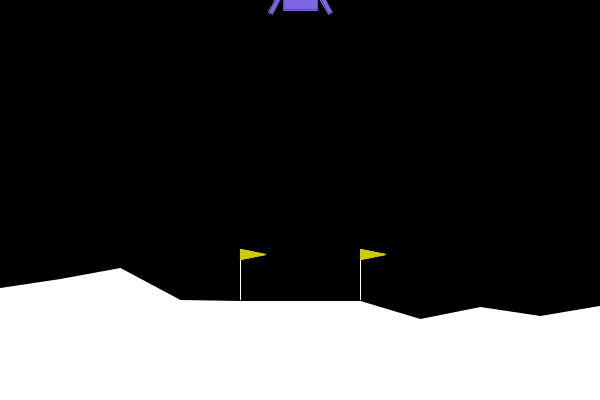

In [34]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [35]:
#Determinar o tamanho do estado
state_size = env.observation_space.shape

#Determinando o numero de ações
num_actions = env.action_space.n

print('Tamanho do estado', state_size)
print('Números de ações', num_actions)

Tamanho do estado (8,)
Números de ações 4


In [36]:
#retornando ao estado inicial
current_state = env.reset

In [37]:
#Definindo o número de ações
action = 0

'''
Definindo valores recebidos depois que foi gerado uma ação.

Next_state = Proximo estado
Reward = A recompensa que recebe
Done = Verificar se houve o encerramento da ação
_ = Descarta informações que não será utilizadas

'''

next_state, reward, done, _ = env.step(action)


#Apos isso o estado atual recebe o proximo estado
current_state = next_state



In [38]:
#Criando o modelo para transformação
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
])

target_q_network = Sequential([
      Input(shape=state_size),
      Dense(units=64, activation='relu'),
      Dense(units=64, activation='relu'),
      Dense(units=num_actions, activation='linear')

    ])

optimizer = Adam(learning_rate=ALPHA)

In [39]:
#Criando uma colection parecido com uma tupla com nomes de campos
experience = namedtuple('Experience', field_names=['state', 'action','reward', 'next_state', 'done'])

In [40]:
def compute_loss(experiences, gamma, q_network, target_q_network):

  #vai buscar os dados da colection 'Experience' e adicionar nas variaveis correspondentes
  states, actions, rewards, next_states, done_vals = experiences

  #Vai calcular o maior Q(s,a) de cada ação possivel
  max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

  '''
  Calculo do teorema de Bellman
  Recompensa + gamma * max_qsa
  e a parte (1 - done_vals) é verificar se ja houve a ação de mover para o proximo estado, se houve o valor não muda
  '''
  y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

  #Rodar o modelo q_netowrk com os states e depois agrupa-los juntos as ações
  q_values = q_network(states)
  q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                              tf.cast(actions, tf.int32)
                                              ], axis=1))

  #Calcular o erro quadratico
  loss = MSE(y_targets, q_values)

  return loss


In [41]:
#atualizando os pesos
def update_target_network(q_network, target_q_network):
  for target_weights, q_net_weights in zip(
      target_q_network.weights, q_network.weights
  ):
      target_weights.assign(TAU *  q_net_weights + (1.0 - TAU) * target_weights)

In [42]:
@tf.function

#Aprendizado de reforço
def agent_learn(experiences, gamma):
  with tf.GradientTape() as tape:

    loss = compute_loss(experiences, gamma, q_network, target_q_network)

  gradients = tape.gradient(loss, q_network.trainable_variables)

  optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

  update_target_network(q_network, target_q_network)

In [43]:
def get_action(q_values, epsilon=0.0):
  if random.random() > epsilon:
    return np.argmax(q_values.numpy()[0])
  else:
    return random.choice(np.arange(4))

In [44]:
#adicionar os valores ao colection Experience
def get_experiences(memory_buffer):
  #gerando as informações aleatorias
  experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
  #Adicionando aos campos, se não estiver vazio ele passa para o proximo
  states = tf.convert_to_tensor(
      np.array([e.state for e in experiences if e is not None]), dtype=tf.float32
  )
  actions = tf.convert_to_tensor(
      np.array([e.action for e in experiences if e is not None]),dtype=tf.float32
  )
  rewards = tf.convert_to_tensor(
      np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32
  )
  next_states = tf.convert_to_tensor(
      np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32
  )
  done_vals = tf.convert_to_tensor(
      np.array([e.done for e in experiences if e is not None]).astype(np.uint8), dtype=tf.float32
  )

  return (states, actions, rewards, next_states, done_vals)

In [45]:
#Verificar as condições de atualizações dos dados
def check_update_conditions(t, num_steps_upd, memory_buffer):
  if(t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
    return True
  else:
    return False

In [46]:
def get_new_eps(epsilon):
  return max(E_MIN, E_DECAY * epsilon)

In [47]:
start = time.time()

#Quantidades de informações geradas
num_episodes = 2000
#Quantidade de etapas a ser realizado
max_num_timesteps = 1000

#Guarda as informações das recompensas ganhas
total_point_history = []


num_p_av = 100
epsilon = 1.0

#Variavel da experiencias geradas
memory_buffer = deque(maxlen=MEMORY_SIZE)

#Atualizar o vetor
target_q_network.set_weights(q_network.get_weights())

#loop sobre os episodios
for i in range(num_episodes):

  #resetando o estado
  state = env.reset()
  total_points = 0
  #loop sobre as etapas
  for t in range(max_num_timesteps):

    state_qn = np.expand_dims(state, axis=0)
    q_values = q_network(state_qn)
    action = get_action(q_values, epsilon)

    #Retorna ambiente apos tomar uma ação
    next_state, reward, done, _ = env.step(action)

    #Atualização das novas experiencias adquiridas
    memory_buffer.append(experience(state, action, reward, next_state, done))

    #Verificar se é preciso atualizar as informações da rede Q
    update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

    # Se for atualizado a experiencia nova vai ser aprendida
    if update:
      experiences = get_experiences(memory_buffer)

      agent_learn(experiences, GAMMA)

    #O que era o proximo estado se torna o estado atual
    state = next_state.copy()
    #Calcula o valor das recompensas
    total_points += reward

    if done:
      break

    total_point_history.append(total_points)
    av_lastest_points = np.mean(total_point_history[-num_p_av:])

    epsilon = get_new_eps(epsilon)

    print(f"\r Episode {i+1} | Total point average of the last{num_p_av} episodes: {av_lastest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
      print(f"\r Episode {i+1} | Total point average of the last{num_p_av} episodes: {av_lastest_points:.2f}")

    #Se o valor das medias forem 200 o ambiente considera resolvido
    if av_lastest_points >= 200.0:
      print(f"\n\n Evironment solved in {i+1} episodes!")
      q_network.save('lunar_lander_model.h5')
      break

tot_time = time.time() - start

print(f'\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)')

A saída de streaming foi truncada nas últimas 5000 linhas.
 Episode 400 | Total point average of the last100 episodes: -51.59
 Episode 400 | Total point average of the last100 episodes: -51.83
 Episode 400 | Total point average of the last100 episodes: -52.09
 Episode 400 | Total point average of the last100 episodes: -52.35
 Episode 400 | Total point average of the last100 episodes: -52.61
 Episode 400 | Total point average of the last100 episodes: -52.89
 Episode 400 | Total point average of the last100 episodes: -53.15
 Episode 400 | Total point average of the last100 episodes: -53.40
 Episode 400 | Total point average of the last100 episodes: -53.66
 Episode 400 | Total point average of the last100 episodes: -53.90
 Episode 400 | Total point average of the last100 episodes: -54.19
 Episode 400 | Total point average of the last100 episodes: -54.43
 Episode 400 | Total point average of the last100 episodes: -54.66
 Episode 400 | Total point average of the last100 episodes: -54.91
 Ep

 Episode 1428 | Total point average of the last100 episodes: 200.15

 Evironment solved in 1428 episodes!
 Episode 1500 | Total point average of the last100 episodes: 115.45
 Episode 1500 | Total point average of the last100 episodes: 114.95
 Episode 1500 | Total point average of the last100 episodes: 114.43
 Episode 1500 | Total point average of the last100 episodes: 113.89
 Episode 1500 | Total point average of the last100 episodes: 113.31
 Episode 1500 | Total point average of the last100 episodes: 112.75
 Episode 1500 | Total point average of the last100 episodes: 112.14
 Episode 1500 | Total point average of the last100 episodes: 111.53
 Episode 1500 | Total point average of the last100 episodes: 110.88
 Episode 1500 | Total point average of the last100 episodes: 110.21
 Episode 1500 | Total point average of the last100 episodes: 109.49
 Episode 1500 | Total point average of the last100 episodes: 108.76
 Episode 1500 | Total point average of the last100 episodes: 108.06
 Episode 1

In [48]:
def embed_mp4(filename):
  video = open(filename, "rb").read()
  b64 = base64.b64encode(video)
  tag=""
  format(
      b64.decode
  )
  return IPython.display.HTML(tag)

In [49]:
def create_video(filename, env, q_network, fps=30):
  with imageio.get_writer(filename, fps=fps) as video:
    done = False
    state = env.reset()
    frame = env.render(mode="rgb_array")
    video.append_data(frame)
    while not done:
      state = np.expand_dims(state, axis=0)
      q_values = q_network(state)
      action = np.argmax(q_values.numpy()[0])
      state, _, done, _ = env.step(action)
      frame = env.render(mode="rgb_array")
      video.append_data(frame)

In [50]:
filename= "lunar_lander.mp4"
create_video(filename, env,q_network)
embed_mp4(filename)